# Introduction 

This builds a basic VAMPnets model without the deeptime module. The resulting output will still be put in a deptime VAMP model to compare to the deeptime version. 

In [1]:
from copy import deepcopy
from pathlib import Path
from typing import List, Tuple, Callable
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.parameter import Parameter
import torch.nn.functional as F


from addict import Dict

from deeptime.util.types import to_dataset
from deeptime.decomposition import VAMP
from deeptime.decomposition.deep import VAMPNet, vampnet_loss, VAMPNetModel

## Functions

In [2]:
assert torch.cuda.is_available(), "Need a GPU with CUDA" 
torch.backends.cudnn.benchmark = True

In [55]:
# def its(model, config):
#     lagtimes = np.arange(1, 201, dtype=np.int32)
#     timescales = []
#     for lag in lagtimes:
#         ts = VAMP(lagtime=lag, observable_transform=model).fit(data).fetch_model().timescales(k=config.output_dim-1)
#         timescales.append(ts)
#     return lagtimes, timescales

class CelerityVAMPNet(nn.Module):
    def __init__(self, 
                input_dim: int, 
                output_dim: int, 
                n_hidden_layers: int, 
                hidden_layer_width: int,
                loss: Callable[[np.ndarray, np.ndarray], float],
                use_cuda: bool = True, 
                batch_size: int = 2, 
                b: float = 0.99, 
                n: float = 0.01, # Weight update learning rate 
                s: float = 0.1
                ):
        super(CelerityVAMPNet, self).__init__()

        # Setup device
        if torch.cuda.is_available() and use_cuda:
            print("Using CUDA :]")

        self.device = torch.device(
            "cuda:0" if torch.cuda.is_available() and use_cuda else "cpu")

        self.loss = loss
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.batch_size = batch_size
        assert self.batch_size > 1, "Covariance estimators need two samples at least"
        # Setup layers
        hidden_layers = []
        output_layers = []
        self.n_hidden_layers = n_hidden_layers
        hidden_layers.append(nn.Linear(input_dim, hidden_layer_width))
        for i in range(n_hidden_layers-1): 
            hidden_layers.append(
                nn.Linear(hidden_layer_width, hidden_layer_width)
            )
        for i in range(n_hidden_layers): 
            output_layers.append(nn.Linear(hidden_layer_width, output_dim)) 

        self.hidden_t_0 = nn.ModuleList(hidden_layers).to(self.device)
        self.output_t_0 = nn.ModuleList(output_layers).to(self.device)
        

        # Other training parameters
        self.b = Parameter(torch.tensor(
            b), requires_grad=False).to(self.device)
        self.n = Parameter(torch.tensor(
            n), requires_grad=False).to(self.device)
        self.s = Parameter(torch.tensor(
            s), requires_grad=False).to(self.device)

        self.alpha = Parameter(torch.Tensor(self.n_hidden_layers).fill_(1 / (self.n_hidden_layers + 1)),
                               requires_grad=False).to(
            self.device)

        # Output accumulators
        self.loss_array = []
        self.alpha_array = []

    def partial_forward(self, hidden_module: nn.Module, output_module: nn.Module, x: torch.Tensor) -> List[torch.Tensor]: 
        hidden_connections = []
        X = x.to(self.device)
        # X = torch.reshape(X, (self.batch_size, -1))
        # push forward through main network
        hidden_connections.append(F.elu(hidden_module[0](X)))
        for i in range(1, self.n_hidden_layers): 
            tmp = hidden_module[i](hidden_connections[i-1])
            hidden_connections.append(F.elu(tmp))

        # push through outputs
        predictions_per_layer = []
        for i in range(self.n_hidden_layers): 
            tmp = output_module[i](hidden_connections[i])
            predictions_per_layer.append(F.softmax(tmp, dim=1))
        return predictions_per_layer 

    def zero_grad(self):
        for i in range(self.n_hidden_layers):
            self.hidden_t_0[i].zero_grad()
            self.output_t_0[i].zero_grad()

    def forward(self, x: List[torch.Tensor]) -> Tuple[List[torch.Tensor]]:
        x_0, x_tau = x[0], x[1]
        pred_0_per_layer = self.partial_forward(self.hidden_t_0, self.output_t_0, x_0)
        pred_tau_per_layer = self.partial_forward(self.hidden_t_0, self.output_t_0, x_tau)
        return (pred_0_per_layer, pred_tau_per_layer)

    def loss_per_layer(self, predictions_per_layer: Tuple[List[torch.Tensor]]) -> List[torch.Tensor]: 
        losses_per_layer = []
   
        for pred_0, pred_tau in zip(*predictions_per_layer):
            loss = self.loss(pred_0, pred_tau) 
            losses_per_layer.append(loss)
        return losses_per_layer


    def predict(self, x: List[torch.Tensor]) -> float: 
        preds_by_layer = self.forward(x)
        loss_by_layer = self.loss_per_layer(preds_by_layer)
        loss_by_layer = torch.stack(loss_by_layer)
        average_loss = torch.sum(torch.mul(model.alpha, loss_by_layer))
        return float(average_loss)

    def get_alphas(self) -> np.ndarray: 
        if self.device.type == 'cuda': 
            return model.alpha.to('cpu').numpy()
        else: 
            return model.alpha.numpy()


    def update_weights(self, X: List[torch.Tensor]) -> None: 
        predictions_per_layer = self.forward(X)
        losses_per_layer = self.loss_per_layer(predictions_per_layer)

        w = [None] * len(losses_per_layer)
        b = [None] * len(losses_per_layer)
        
        with torch.no_grad():   
            for i in range(len(losses_per_layer)):

                losses_per_layer[i].backward(retain_graph=True)             
                self.output_t_0[i].weight.data -= self.n * \
                                                   self.alpha[i] * self.output_t_0[i].weight.grad.data
                self.output_t_0[i].bias.data -= self.n * \
                                                 self.alpha[i] * self.output_t_0[i].bias.grad.data

                for j in range(i + 1):
                    if w[j] is None:
                        w[j] = self.alpha[i] * self.hidden_t_0[j].weight.grad.data
                        b[j] = self.alpha[i] * self.hidden_t_0[j].bias.grad.data
                    else:
                        w[j] += self.alpha[i] * self.hidden_t_0[j].weight.grad.data
                        b[j] += self.alpha[i] * self.hidden_t_0[j].bias.grad.data

                self.zero_grad()

            for i in range(len(losses_per_layer)):
                self.hidden_t_0[i].weight.data -= self.n * w[i]
                self.hidden_t_0[i].bias.data -= self.n * b[i]

            for i in range(len(losses_per_layer)):
                self.alpha[i] *= torch.pow(self.b, losses_per_layer[i])
                self.alpha[i] = torch.max(
                    self.alpha[i], self.s / self.n_hidden_layers)
        
        z_t = torch.sum(self.alpha)
        self.alpha = Parameter(
            self.alpha / z_t, requires_grad=False).to(self.device)

    def partial_fit(self, X: List[torch.Tensor]) -> None: 
        self.update_weights(X)

In [53]:
data_dir = "/home/rob/online_vampnets/data"
coordinates_path = Path(data_dir).joinpath('alanine-dipeptide-3x250ns-heavy-atom-positions.npz')
dihedrals_path = Path(data_dir).joinpath('alanine-dipeptide-3x250ns-backbone-dihedrals.npz')
with np.load(coordinates_path.open('rb')) as fh:
    data = [fh[f"arr_{i}"].astype(np.float32) for i in range(3)]

with np.load(dihedrals_path.open('rb')) as fh:
    dihedral = [fh[f"arr_{i}"] for i in range(3)]


In [68]:
all_data = np.concatenate(data)
mean = np.mean(all_data, axis=0)
std = np.std(all_data, axis=0)
norm_data = []
for x in data:
    norm_data.append((x - mean)/std) 


In [69]:
lag_time = 1
validation_split = 0.3
batch_size = 100
dataset = to_dataset(data=norm_data, lagtime=lag_time)
n_val = int(len(dataset)*validation_split)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])
loader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False) 

In [70]:
alphas = []
test_scores = []
train_scores = []
record_interval = 100

loss = partial(vampnet_loss, method='VAMP2', mode='regularize', epsilon=1e-6)

model = CelerityVAMPNet(input_dim=30, output_dim=6, 
                        n_hidden_layers=5, 
                        hidden_layer_width=100, 
                        batch_size=batch_size, 
                        loss=loss)

for i, x in enumerate(loader_train):
    model.partial_fit(x)

    if i % record_interval == 0: 
        print(f"{i/len(loader_train):2%}")
        alphas.append(model.get_alphas())
        train_scores.append(-model.predict(x))
        tmp = []
        for val in loader_val: 
            tmp.append(-model.predict(val))
        test_scores.append(np.mean(tmp))


Using CUDA :]
0.000000%
1.904762%
3.809524%
5.714286%
7.619048%
9.523810%
11.428571%
13.333333%
15.238095%
17.142857%
19.047619%
20.952381%
22.857143%
24.761905%
26.666667%
28.571429%
30.476190%
32.380952%
34.285714%
36.190476%
38.095238%
40.000000%
41.904762%
43.809524%
45.714286%
47.619048%
49.523810%
51.428571%
53.333333%
55.238095%
57.142857%
59.047619%
60.952381%
62.857143%
64.761905%
66.666667%
68.571429%
70.476190%
72.380952%
74.285714%
76.190476%
78.095238%
80.000000%
81.904762%
83.809524%
85.714286%
87.619048%
89.523810%
91.428571%
93.333333%
95.238095%
97.142857%
99.047619%


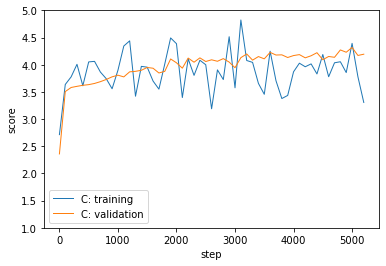

In [81]:
plt.plot(np.arange(len(test_scores))*record_interval,train_scores, label='C: training',lw=1)

plt.plot(np.arange(len(test_scores))*record_interval, test_scores, label='C: validation',lw=1)
plt.xlabel('step')
plt.ylabel('score')
# plt.xscale('log')
plt.legend();
plt.ylim(1, 5)

plt.savefig('celerity_training.png')

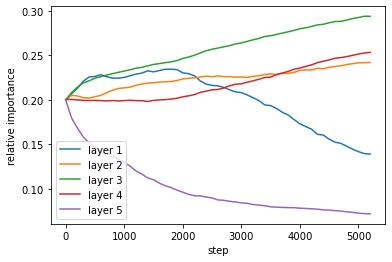

In [80]:
for i in range(model.n_hidden_layers): 
    plt.plot(np.arange(len(test_scores))*record_interval,np.array(alphas)[:, i], label=f'layer {i+1}')
plt.legend()
# plt.xscale('log')
plt.xlabel('step')
plt.ylabel('relative importance')
plt.savefig('celerity_alphas.png')